## This notebook was created to replicate Michael Prather's 2007 paper "Lifetimes and time scales in atmoshperic chemistry" for the "Tropospheric methane chemistry:delayed recovery of a perturbation" section. 

Betsy Farris
for Chem 5152, 2025 (CU Boulder)
Student Choice Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Create the Jacobian

In [2]:
# From Prather, X value estimated from his final Jacobian values

# Initial mixing ratios (ppb)
y = np.array([1704, 100, 0.000026])  # [CH4, CO, OH] # modern global mean = 1938 ppb; Prather 2007 = 1704 ppb for methane
x_ppb = 0.001  # External sink species (held constant)

# Source Terms (ppb yr-1)
S = np.array([177, 240, 1464])  # [S_CH4, S_CO, S_OH]

# Reaction rates (converted to per year)
k5 = 1.266e-4 * 3.156e7  # CH4 + OH (yr-1 ppb-1)
k6 = 5.08e-3 * 3.156e7   # CO + OH (yr-1 ppb-1)
k7 = 1062 * 3.156e7      # OH + X (yr-1)

# Reaction function with x included only internally
def reaction_rates(y):
    ch4, co, oh = y
    R5 = k5 * ch4 * oh
    R6 = k6 * co * oh
    R7 = k7 * oh * x_ppb  # OH loss to external X
    dCH4dt = S[0] - R5
    dCOdt = S[1] + R5 - R6
    dOHdt = S[2] - R5 - R6 - R7
    return np.array([dCH4dt, dCOdt, dOHdt])

# Base rate
base_rates_co = reaction_rates(y)

# Jacobian (numerical)
pert = 1  # 1 ppb
J_co = np.zeros((3, 3))

for i in range(3):
    y_pert = y.copy()
    y_pert[i] += pert
    pert_rates = reaction_rates(y_pert)
    J_co[:, i] = (pert_rates - base_rates_co) / pert

# Display Jacobian
species = ["CH4", "CO", "OH"]
print("Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:")
for i in range(3):
    for j in range(3):
        print(f"∂(d[{species[i]}]/dt)/∂[{species[j]}] = {J_co[i,j]:.6e}")


Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:
∂(d[CH4]/dt)/∂[CH4] = -1.038829e-01
∂(d[CH4]/dt)/∂[CO] = 0.000000e+00
∂(d[CH4]/dt)/∂[OH] = -6.808325e+06
∂(d[CO]/dt)/∂[CH4] = 1.038829e-01
∂(d[CO]/dt)/∂[CO] = -4.168445e+00
∂(d[CO]/dt)/∂[OH] = -9.224155e+06
∂(d[OH]/dt)/∂[CH4] = -1.038829e-01
∂(d[OH]/dt)/∂[CO] = -4.168445e+00
∂(d[OH]/dt)/∂[OH] = -5.635753e+07


## Compute eigenvalues and eigenvectors to find modes

In [4]:
eigenvalues_co, eigenvectors_co = np.linalg.eig(J_co)

# Compute lifetimes (in years)
T_years_co = -1 / eigenvalues_co

# Print results
print("Eigenvalues:")
for i, val in enumerate(eigenvalues_co):
    print(f"  λ{i+1} = {val:.4e}")

print("\nPerturbation lifetimes (in years):")
for i, T in enumerate(T_years_co):
    print(f"  Mode {i+1}: {T.real:.9f} years")

print("\nEigenvectors (columns are eigenmodes):")
print(eigenvectors_co)



t = np.arange(0, 100, 5)
delta_ch4_1ppb_co = 0.995*np.exp(-t/T_years_co[1])+0.005*np.exp(-t/T_years_co[2])

delta_ch4_trad = np.exp(-t/9.626224)

Eigenvalues:
  λ1 = -5.6358e+07
  λ2 = -7.3495e-02
  λ3 = -3.5040e+00

Perturbation lifetimes (in years):
  Mode 1: 0.000000018 years
  Mode 2: 13.606280603 years
  Mode 3: 0.285386143 years

Eigenvectors (columns are eigenmodes):
[[ 1.18381327e-01 -9.99373217e-01 -1.45978241e-01]
 [ 1.60387135e-01 -3.54001732e-02  9.89287801e-01]
 [ 9.79929502e-01  4.46047713e-09 -7.29029032e-08]]


## Coefficients for 1ppb pertubation CH4

In [5]:
# Checking delta_ch4_1ppb equation from matrix projection (not just copying Prather's text)

# X0 = V*c where c is intial conditions
# so c=V_inverse*X0
# Methane looks right but CO is lower than Prather's 0.005 (ignored OH)

Init_1ppb_co = np.array( [1, 0, 0] ) #sticking with 3x3 even though Prather drops OH
V_inv_co = np.linalg.inv(eigenvectors_co) #inverse of the eignvectors
coeffs_co = V_inv_co @ Init_1ppb_co

for i in range(3):
    print(f"Mode {i+1}:")
    print(f"  Eigenvalue (decay rate): {eigenvalues_co[i]:.4f}")
    print(f"  Lifetime: {-1/eigenvalues_co[i]:.2f} years")
    print(f"  Contribution coefficient: {coeffs_co[i]:.4f}")

delta_ch4_1ppb_co = abs(coeffs_co[1])*np.exp(-t/T_years_co[1])+abs(coeffs_co[2])*np.exp(-t/T_years_co[2])

Mode 1:
  Eigenvalue (decay rate): -56357525.8788
  Lifetime: 0.00 years
  Contribution coefficient: 0.0000
Mode 2:
  Eigenvalue (decay rate): -0.0735
  Lifetime: 13.61 years
  Contribution coefficient: -0.9954
Mode 3:
  Eigenvalue (decay rate): -3.5040
  Lifetime: 0.29 years
  Contribution coefficient: -0.0356


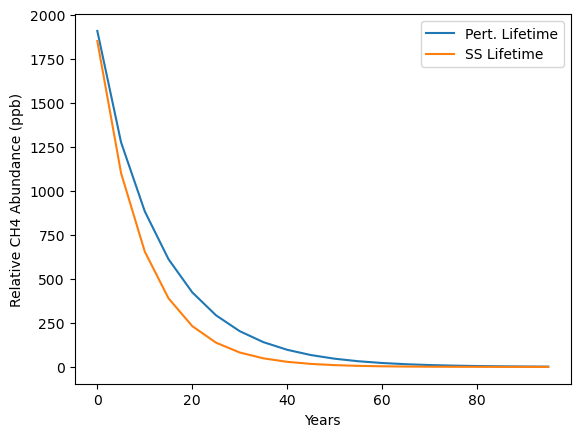

In [6]:
plt.plot(t,1850*delta_ch4_1ppb_co)
plt.plot(t, 1850*delta_ch4_trad)
plt.xlabel('Years')
plt.ylabel("Relative CH4 Abundance (ppb)")
plt.legend(["Pert. Lifetime", "SS Lifetime"])

In [7]:
diag_co = np.diag(J_co)
species = ["CH4", "CO", "OH"]

print("Negative Inverse of Diagonal of Jacobian (∂(d[species]/dt)/∂[same species]): Traditional Lifetime")
for i in range(3):
    print(f"∂(d[{species[i]}]/dt)/∂[{species[i]}] = {-1/diag_co[i]:.6e}")

Negative Inverse of Diagonal of Jacobian (∂(d[species]/dt)/∂[same species]): Traditional Lifetime
∂(d[CH4]/dt)/∂[CH4] = 9.626224e+00
∂(d[CO]/dt)/∂[CO] = 2.398976e-01
∂(d[OH]/dt)/∂[OH] = 1.774386e-08


## Extending Chemical Coupling to HCHO:
Question asked-- how would including HCHO in the Prather's model change the lifetime of CH4?
- How does HCHO's lifetime compare to its formation from CH4
- how does photolysis reate of removal compare to its oxidation (taking away from OH from CH4)

From TUV-X: https://www.acom.ucar.edu/Models/TUV/Interactive_TUV/tuv-x.shtml\
Photolysis Rates of HCHO (Boulder 19h 20230308)\
30 CH2O+hv->H+HCO                          2.69873e-05\
31 CH2O+hv->H2+CO                          4.23498e-05\
\
From IUPAC:\
k = 8.5 x 10-12 cm3 molecule-1 s-1 at 298 K. (HO + HCHO --> H2O + HCO)\
k = 7.9 x 10-14 cm3 molecule-1 s-1 at 298 K. (HO2 + HCHO --> HOCH2OO)

Source and Steady State Concentrations: 
https://acp.copernicus.org/articles/23/2997/2023/
# Source and Steady State Concentrations
S_hcho = 0.73*8765 #  (ppb/year)\
hcho = 2 #ppb\ 

In [8]:
# Print Values for Comparision with CO
k_hcho_cm = 8.5e-12 #cm3/molecules/s
k_hcho_ppb = k_hcho_cm*3.156e7*2.46e10 #(ppb/year)
print(f"ks: {k_hcho_ppb} yr-1 ppb-1 HCHO vs {3.08e-3} yr-1 ppb-1 CO" )
print(f"Sources: {0.73*8765} ppb yr-1 HCHO vs 240 ppb yr-1")


ks: 6599196.0 yr-1 ppb-1 HCHO vs 0.00308 yr-1 ppb-1 CO
Sources: 6398.45 ppb yr-1 HCHO vs 240 ppb yr-1


## Redo with HCHO instead of CO

In [9]:
# From Prather, X value estimated from his final Jacobian values

# Initial mixing ratios (ppb)
y_hcho = np.array([1704, 2, 0.000026])  # [CH4, CO, OH] # modern global mean = 1938 ppb; Prather 2007 = 1704 ppb for methane
x_ppb = 0.001  # External sink species (held constant)

# Source Terms (ppb yr-1)
S_hcho = np.array([177, 0.73*8765, 1464])  # [S_CH4, S_CO, S_OH]

# Reaction rates (converted to per year)
k5 = 1.266e-4 * 3.156e7  # CH4 + OH (yr-1 ppb-1) -- ASSUMES formation of CO still !!!!
k6 = 8.5e-12 * 3.156e7*2.46e10 #(ppb/year)   # HCHO + OH (yr-1 ppb-1)
k7 = 1062 * 3.156e7      # OH + X (yr-1)

# Reaction function with x included only internally
def reaction_rates(y_hcho):
    ch4, hcho, oh = y_hcho
    R5 = k5 * ch4 * oh
    R6 = k6 * hcho * oh
    R7 = k7 * oh * x_ppb  # OH loss to external X
    dCH4dt = S_hcho[0] - R5
    dHCHOdt = S_hcho[1] + R5 - R6
    dOHdt = S_hcho[2] - R5 - R6 - R7
    return np.array([dCH4dt, dHCHOdt, dOHdt])

# Base rate
base_rates_hcho = reaction_rates(y_hcho)

# Jacobian (numerical): perturb each species by +1ppb and take the difference from the base case; divide by 1 ppb
pert = 1  # 1 ppb
J_hcho = np.zeros((3, 3))

for i in range(3):
    y_pert = y.copy()
    y_pert[i] += pert #each species
    pert_rates = reaction_rates(y_pert) # calc rates with pert.
    J_hcho[:, i] = (pert_rates - base_rates_hcho) / pert #save to J

# Display Jacobian
species = ["CH4", "HCHO", "OH"]
print("Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:")
for i in range(3):
    for j in range(3):
        print(f"∂(d[{species[i]}]/dt)/∂[{species[j]}] = {J_hcho[i,j]:.6e}")
#%%%%%%%%%%
# Eigenvalue Decomp
#%%%%%%%%%%%

eigenvalues_hcho, eigenvectors_hcho = np.linalg.eig(J_hcho)

# Compute lifetimes (in years)
T_years_hcho = -1 / eigenvalues_hcho

# Print results
print("Eigenvalues:")
for i, val in enumerate(eigenvalues_hcho):
    print(f"  λ{i+1} = {val:.4e}")

print("\nPerturbation lifetimes (in years):")
for i, T in enumerate(T_years_hcho):
    print(f"  Mode {i+1}: {T.real:.9f} years")

print("\nEigenvectors (columns are eigenmodes):")
print(eigenvectors_hcho)

#initial Conditions solving for C
Init_1ppb_hcho = np.array( [1, 0, 0] ) #sticking with 3x3 even though Prather drops OH
V_inv_hcho = np.linalg.inv(eigenvectors_hcho) #inverse of the eignvectors
coeffs_hcho = V_inv_hcho @ Init_1ppb_hcho

for i in range(3):
    print(f"Mode {i+1}:")
    print(f"  Eigenvalue (decay rate): {eigenvalues_hcho[i]:.4f}")
    print(f"  Lifetime: {-1/eigenvalues_hcho[i]:.2f} years, {-1/eigenvalues_hcho[i]*8760:.2f} hours")
    print(f"  Contribution coefficient: {coeffs_hcho[i]:.4f}")


Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:
∂(d[CH4]/dt)/∂[CH4] = -1.038829e-01
∂(d[CH4]/dt)/∂[HCHO] = 0.000000e+00
∂(d[CH4]/dt)/∂[OH] = -6.808325e+06
∂(d[HCHO]/dt)/∂[CH4] = -1.681465e+04
∂(d[HCHO]/dt)/∂[HCHO] = -1.698633e+04
∂(d[HCHO]/dt)/∂[OH] = -6.531281e+08
∂(d[OH]/dt)/∂[CH4] = -1.681486e+04
∂(d[OH]/dt)/∂[HCHO] = -1.698633e+04
∂(d[OH]/dt)/∂[OH] = -7.002615e+08
Eigenvalues:
  λ1 = -7.0028e+08
  λ2 = -8.6195e-02
  λ3 = -9.7983e+02

Perturbation lifetimes (in years):
  Mode 1: 0.000000001 years
  Mode 2: 11.601568746 years
  Mode 3: 0.001020583 years

Eigenvectors (columns are eigenmodes):
[[-7.10964675e-03 -7.10722883e-01  1.42977764e-01]
 [-6.82050824e-01  7.03472092e-01 -9.89725901e-01]
 [-7.31270214e-01  1.84641915e-09  2.05747165e-05]]
Mode 1:
  Eigenvalue (decay rate): -700277466.4514
  Lifetime: 0.00 years, 0.00 hours
  Contribution coefficient: -0.0000
Mode 2:
  Eigenvalue (decay rate): -0.0862
  Lifetime: 11.60 years, 101629.74 hours
  Contribution coefficient

## Accounting for HCHO Photolysis
jph = photolysis coeff for HCHO+hv in s-1\
from NCAR TUV-x (https://www.acom.ucar.edu/Models/TUV/Interactive_TUV/tuv-x.shtml) \
Boulder 3/8/2023, 19h \
30 CH2O+hv->H+HCO                          2.69873e-05 \
31 CH2O+hv->H2+CO                          4.23498e-05 \

In [28]:
jph_tuvx = (2.7e-5)/2 # s^-1, #using average rate

# From Prather, X value estimated from his final Jacobian values

# Initial mixing ratios (ppb)
y_hcho_hv = np.array([1704, 2, 0.000026])  # [CH4, CO, OH] # modern global mean = 1938 ppb; Prather 2007 = 1704 ppb for methane
x_ppb = 0.001  # External sink species (held constant)

# Source Terms (ppb yr-1)
S_hcho_hv = np.array([177, 0.73*8765, 1464])  # [S_CH4, S_CO, S_OH]

# Reaction rates (converted to per year)
k5 = 1.266e-4 * 3.156e7  # CH4 + OH (yr-1 ppb-1) -- ASSUMES formation of CO still !!!!
k6 = 8.5e-12 * 3.156e7*2.46e10 #(ppb/year)   # HCHO + OH (yr-1 ppb-1)
k7 = 1062 * 3.156e7      # OH + X (yr-1)
j8 = jph_tuvx * 3.156e7 # (yr-1)

# Reaction function with x included only internally
def reaction_rates(y_hcho_hv):
    ch4, hcho, oh = y_hcho_hv
    R5 = k5 * ch4 * oh
    R6 = k6 * hcho * oh
    R7 = k7 * oh * x_ppb  # OH loss to external X
    R8 = j8 * hcho #loss due to photolysis
    dCH4dt = S_hcho_hv[0] - R5
    dHCHOdt = S_hcho_hv[1] + R5 - R6 - R8
    dOHdt = S_hcho_hv[2] - R5 - R6 - R7
    return np.array([dCH4dt, dHCHOdt, dOHdt])

# Base rate
base_rates_hcho_hv = reaction_rates(y_hcho_hv)

# Jacobian (numerical): perturb each species by +1ppb and take the difference from the base case; divide by 1 ppb
pert = 1  # 1 ppb
J_hcho_hv = np.zeros((3, 3))

for i in range(3):
    y_pert = y.copy()
    y_pert[i] += pert #each species
    pert_rates = reaction_rates(y_pert) # calc rates with pert.
    J_hcho_hv[:, i] = (pert_rates - base_rates_hcho_hv) / pert #save to J

# Display Jacobian
species = ["CH4", "HCHO", "OH"]
print("Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:")
for i in range(3):
    for j in range(3):
        print(f"∂(d[{species[i]}]/dt)/∂[{species[j]}] = {J_hcho_hv[i,j]:.6e}")
#%%%%%%%%%%
# Eigenvalue Decomp
#%%%%%%%%%%%

eigenvalues_hcho_hv, eigenvectors_hcho_hv = np.linalg.eig(J_hcho_hv)

# Compute lifetimes (in years)
T_years_hcho_hv = -1 / eigenvalues_hcho_hv

# Print results
print("Eigenvalues:")
for i, val in enumerate(eigenvalues_hcho_hv):
    print(f"  λ{i+1} = {val:.4e}")

print("\nPerturbation lifetimes (in years):")
for i, T in enumerate(T_years_hcho_hv):
    print(f"  Mode {i+1}: {T.real:.9f} years")

print("\nEigenvectors (columns are eigenmodes):")
print(eigenvectors_hcho_hv)

#initial Conditions solving for C
Init_1ppb_hcho_hv = np.array( [1, 0, 0] ) #sticking with 3x3 even though Prather drops OH
V_inv_hcho_hv = np.linalg.inv(eigenvectors_hcho_hv) #inverse of the eignvectors
coeffs_hcho_hv = V_inv_hcho_hv @ Init_1ppb_hcho_hv

for i in range(3):
    print(f"Mode {i+1}:")
    print(f"  Eigenvalue (decay rate): {eigenvalues_hcho_hv[i]:.4f}")
    print(f"  Lifetime: {-1/eigenvalues_hcho_hv[i]:.2f} years, {-1/eigenvalues_hcho_hv[i]*8760:.2f} hours, {-1/eigenvalues_hcho_hv[i]*8760*3600:.2f} sec")
    print(f"  Contribution coefficient: {coeffs_hcho_hv[i]:.4f}")


Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:
∂(d[CH4]/dt)/∂[CH4] = -1.038829e-01
∂(d[CH4]/dt)/∂[HCHO] = 0.000000e+00
∂(d[CH4]/dt)/∂[OH] = -6.808325e+06
∂(d[HCHO]/dt)/∂[CH4] = -5.856853e+04
∂(d[HCHO]/dt)/∂[HCHO] = -5.916627e+04
∂(d[HCHO]/dt)/∂[OH] = -6.531698e+08
∂(d[OH]/dt)/∂[CH4] = -1.681486e+04
∂(d[OH]/dt)/∂[HCHO] = -1.698633e+04
∂(d[OH]/dt)/∂[OH] = -7.002615e+08
Eigenvalues:
  λ1 = -7.0028e+08
  λ2 = -1.0249e-01
  λ3 = -4.3158e+04

Perturbation lifetimes (in years):
  Mode 1: 0.000000001 years
  Mode 2: 9.756643557 years
  Mode 3: 0.000023171 years

Eigenvectors (columns are eigenmodes):
[[ 7.10923402e-03  7.10687814e-01  3.81244061e-03]
 [ 6.82096339e-01 -7.03507520e-01 -9.99992732e-01]
 [ 7.31227764e-01 -1.44952522e-10  2.41668939e-05]]
Mode 1:
  Eigenvalue (decay rate): -700277468.4285
  Lifetime: 0.00 years, 0.00 hours, 0.05 sec
  Contribution coefficient: 0.0000
Mode 2:
  Eigenvalue (decay rate): -0.1025
  Lifetime: 9.76 years, 85468.20 hours, 307685511.23 sec
  

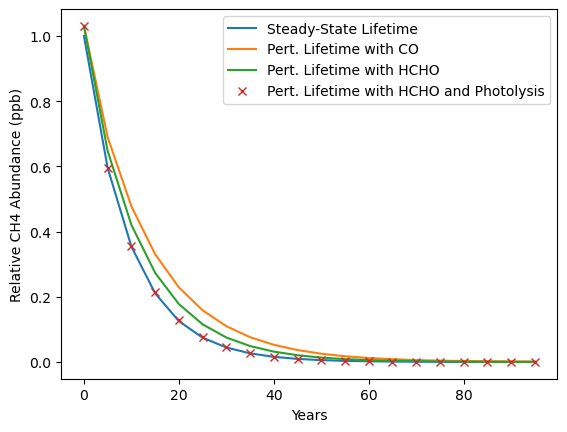

In [30]:
t = np.arange(0, 100, 5)
#using CO coefficients since k5 was not changed for HCHO
delta_ch4_1ppb_hcho_hv = abs(coeffs_co[1])*np.exp(-t/T_years_hcho_hv[1])+abs(coeffs_co[2])*np.exp(-t/T_years_hcho_hv[2])
delta_ch4_1ppb_hcho = abs(coeffs_co[1])*np.exp(-t/T_years_hcho[1])+abs(coeffs_co[2])*np.exp(-t/T_years_hcho[2])
delta_ch4_trad = np.exp(-t/9.626224)

plt.plot(t, delta_ch4_trad)
plt.plot(t,delta_ch4_1ppb_co)
plt.plot(t,delta_ch4_1ppb_hcho)#, 'o')
plt.plot(t,delta_ch4_1ppb_hcho_hv, 'x')
plt.xlabel('Years')
plt.ylabel("Relative CH4 Abundance (ppb)")
plt.legend(["Steady-State Lifetime", "Pert. Lifetime with CO", "Pert. Lifetime with HCHO", "Pert. Lifetime with HCHO and Photolysis"])
plt.savefig("decay_scenerios.png")